In [1]:
# %matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [56]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [109]:
inspector=inspect(engine)
columns_m=inspector.get_columns("Measurement")
columns_s=inspector.get_columns("Station")
for column in columns_m:
    print(column['name'], column['type'])

# for column in columns_s:
#     print(column['name'], column['type'])
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date=session.query(func.max(Measurement.date)).first()
year_date=dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_rain=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>year_date).all()


In [12]:
# Calculate the date 1 year ago from today--NO CURRENT DATA IN CHART
year_ago = dt.date.today() - dt.timedelta(days=365)
year_ago

datetime.date(2017, 9, 24)

In [30]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_rain=pd.DataFrame(list(year_rain), columns=['date','precipitation'])
df_rain.set_index('date', inplace=True)

In [31]:
# Sort the dataframe by date
df_rain=df_rain.sort_values("date")
df_rain.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


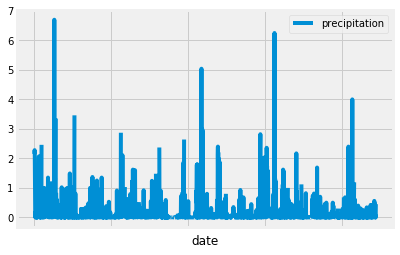

In [32]:
# Use Pandas Plotting with Matplotlib to plot the data
# fig=plt.figure()
df_rain.plot.line()
plt.show()

In [33]:
df_rain.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# How many stations are available in this dataset?
print(session.query(Station.station).distinct().count())

9


In [58]:
# What are the most active stations?
# List the stations and the counts in descending order.
active=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_id=active[0][0]
sel=[func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]
active_info=session.query(*sel).filter(Measurement.station==active_id).all()
active_info

[(54.0, 85.0, 71.66378066378067)]

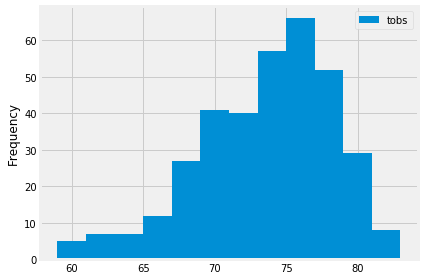

In [79]:
active_pd=pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.date>year_date, Measurement.station==active_id).all())
active_pd.plot.hist(bins=12)
plt.tight_layout()
plt.show()